<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/yolo_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

INF6804 Vision par ordinateur

Polytechnique Montréal

Author: Hughes Perreault

YOLO object detector in inference.

Inspired and partly copied from: https://www.thepythoncode.com/article/yolo-object-detection-with-opencv-and-pytorch-in-python

Import libraries

In [2]:
import cv2
import os 
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from skimage import io


Constants

In [3]:
IMG_BASE_DIR = 'https://raw.githubusercontent.com/gabilodeau/INF6804/master/images'
IMG_NAMES = ['coffee0.jpg', 'coffee1.jpg', 'coffee2.jpg']
THRESHOLD = 0.3  # The confidence score threshold to display a detection box

Download YOLO configuration file and weight file if not done already. Other models exist, see: https://pjreddie.com/darknet/yolo/.

In [4]:
if not os.path.exists('yolov3-tiny.cfg'):
  !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
if not os.path.exists('yolov3-tiny.weights'):
  !wget https://pjreddie.com/media/files/yolov3-tiny.weights

--2020-08-19 14:16:00--  https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1915 (1.9K) [text/plain]
Saving to: ‘yolov3-tiny.cfg’

yolov3-tiny.cfg     100%[===================>]   1.87K  --.-KB/s    in 0s      

2020-08-19 14:16:01 (34.2 MB/s) - ‘yolov3-tiny.cfg’ saved [1915/1915]

--2020-08-19 14:16:07--  https://pjreddie.com/media/files/yolov3-tiny.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35434956 (34M) [application/octet-stream]
Saving to: ‘yolov3-tiny.weights’

yolov3-tiny.weights 100%[===================>]  33.79M   477KB/s    in 82s  

Get the network from the configuration and weights

In [5]:
net = cv2.dnn.readNetFromDarknet('yolov3-tiny.cfg', 'yolov3-tiny.weights')

Get a list of text labels for each integer class id

In [6]:
COCO_NAMES = ['background']
label_names = urllib.request.urlopen('https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names')
for label_name in label_names.readlines():
  COCO_NAMES.append(label_name.strip().decode('UTF-8'))

Get a list of different colors for each label to display the bounding boxes

In [7]:
COLORS = list(mcolors.CSS4_COLORS.values())

For each image in the list, get a list of detection boxes

In [8]:
detections_by_img_name = {}
for img_name in IMG_NAMES:
  img = io.imread(os.path.join(IMG_BASE_DIR, img_name))
  h, w = img.shape[:2]
  blob = cv2.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

  net.setInput(blob)
  ln = net.getLayerNames()
  ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
  layer_outputs = net.forward(ln)

  boxes = []
  for output in layer_outputs:
      for detection in output:
          scores = detection[5:]
          class_id = np.argmax(scores)
          confidence = scores[class_id]
          if confidence > THRESHOLD:
              box = detection[:4] * np.array([w, h, w, h])
              (centerX, centerY, width, height) = box.astype("int")
              x = int(centerX - (width / 2))
              y = int(centerY - (height / 2))
              boxes.append([x, y, int(width), int(height), class_id, confidence])
      detections_by_img_name[img_name] = boxes

For each image in the list, display it's list of detection boxes

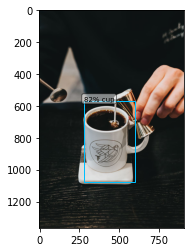

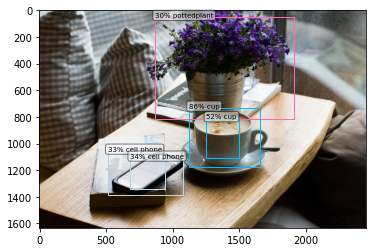

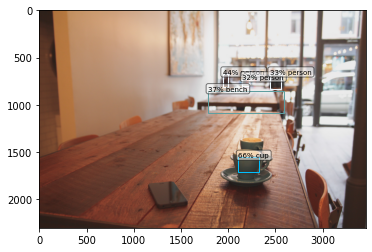

In [9]:
for img_name in detections_by_img_name.keys():
  img = io.imread(os.path.join(IMG_BASE_DIR, img_name))
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  for box in detections_by_img_name[img_name]:
      x0, y0, width, height, label, score = box
      rect = patches.Rectangle((x0, y0), width, height, linewidth=1, edgecolor=COLORS[label], facecolor='none')
      plt.text(x0, y0, str(int(score*100)) + '% ' + COCO_NAMES[label+1], color='k', fontsize=7,
                bbox=dict(facecolor='white', alpha=0.5, boxstyle='round'))
      ax.add_patch(rect)
  plt.show()
  

